In [336]:
import os

from pymatgen.io.vasp.inputs import Structure
import numpy as np
import pandas as pd
#import r2score from sklearn.metrics
from sklearn.metrics import r2_score

from qubitPack.tool_box import get_db

from matplotlib import pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook'])

zfs_db = get_db("qubit_sensor", "cubic_biaxial", port=27017)


/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/atomate/atomate/utils/database.py:51: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if self.db.counter.find({"_id": "taskid"}).count() == 0:


In [337]:
def get_st(st, bottom=24, NN=None):
    data = []
    for st in [st]:
        if not NN:
            NN = e["NN"]
        d = dict(
            zip(
                ["d1", "d2", "d3", "d4", "z1", "z2", "z3", "z4", "a", "b", "c", "NN", "spg"],
                np.array(
                    [st.get_distance(NN[-1], x) for x in NN[:-1]+[bottom] ]+
                    [st.sites[NN[-1]].coords[-1] - st.sites[x].coords[-1] for x in NN[:-1]+[bottom]]+
                    [st.lattice.a/5, st.lattice.b/5, st.lattice.c]+
                    [NN]+
                    [st.get_space_group_info()[0]]
                )))
        data.append(d)
    return data

# Strained ZFS & structure

In [338]:
Ds = []
es = zfs_db.collection.find({"task_label": "pyzfs"})
for e in es:
    taskid = e["task_id"]
    prev_fw_taskid = e["prev_fw_taskid"]
    scf_entry = zfs_db.collection.find_one({"task_id": prev_fw_taskid})
    data = {}
    formula = "".join(e["formula"].split(" "))
    D = e["pyzfs_out"]["D"]/1000
    E = e["pyzfs_out"]["E"]/1000
    strain_ratio = scf_entry["strain_ratio"]
    strain_comp = scf_entry["strain_component"] if "strain_component" in scf_entry else "xx_yy"
    if strain_ratio == 0:
        strain_comp ="pristine"
    data.update({"taskid": taskid, "formula": formula, "D": D, "E":E, "strain_ratio": strain_ratio, "strain_comp": strain_comp,
        "db_info": f"{zfs_db.db_name}.{zfs_db.collection.name}"})
    Ds.append(data)
zfs_df = pd.DataFrame(Ds).sort_values("strain_ratio")
display(zfs_df.round(2))

,taskid,formula,D,E,strain_ratio,strain_comp,db_info
16,124,Mo31S59,8.42,-0.03,-0.06,zz,qubit_sensor.cubic_biaxial
9,100,Mo31S59,5.12,-0.63,-0.06,xx_yy,qubit_sensor.cubic_biaxial
18,129,Mo31S59,8.41,-0.03,-0.05,zz,qubit_sensor.cubic_biaxial
8,99,Mo31S59,6.23,-0.65,-0.05,xx_yy,qubit_sensor.cubic_biaxial
6,95,Mo31S59,7.32,-0.49,-0.04,xx_yy,qubit_sensor.cubic_biaxial
20,133,Mo31S59,8.43,-0.03,-0.04,zz,qubit_sensor.cubic_biaxial
13,115,Mo31S59,8.42,-0.02,-0.03,zz,qubit_sensor.cubic_biaxial
0,83,Mo31S59,8.27,-0.16,-0.03,xx_yy,qubit_sensor.cubic_biaxial
1,85,Mo31S59,8.34,-0.08,-0.02,xx_yy,qubit_sensor.cubic_biaxial
12,113,Mo31S59,8.39,-0.02,-0.02,zz,qubit_sensor.cubic_biaxial


In [339]:
st_df = []
es = zfs_db.collection.find({"task_label": "pyzfs"})
for e in es:
    prev_fw_taskid = e["prev_fw_taskid"]
    scf_entry = zfs_db.collection.find_one({"task_id": prev_fw_taskid})
    st = Structure.from_dict(scf_entry["output"]["structure"])
    formula = scf_entry["formula_pretty"]
    if "Te" in formula:
        bottom = 60
        nn = scf_entry["NN"] #[54, 49, 55, 74]
    else:
        bottom = 60
        nn = scf_entry["NN"] #[5, 6, 0, 25]

    st0 = get_st(st, bottom=bottom, NN=nn)
    st0[0].update(
        {
            "taskid": e["task_id"],
            "formula": formula,
            "strain_ratio": scf_entry["strain_ratio"],
            "structure": st
        }
    )
    st_df.extend(st0)
st_df = pd.DataFrame(st_df)
display(st_df.round(2))

/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/pymatgen/core/lattice.py:1364: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fc = np.array(np.round(fc), dtype=np.int)
/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,NN,spg,taskid,formula,strain_ratio,structure
0,2.65,2.68,2.65,3.62,2.02,2.02,2.02,3.62,3.05,3.17,23.09,"[1, 2, 0, 30]",Pm,83,Mo31S59,-0.03,"[[ 0.03170022 0.01402135 11.40689022] Mo, [ 3..."
1,2.66,2.67,2.66,3.60,2.01,2.01,2.01,3.60,3.08,3.20,23.09,"[1, 2, 0, 30]",Pm,85,Mo31S59,-0.02,"[[ 0.03082428 0.01527161 11.40525081] Mo, [ 3..."
2,2.66,2.66,2.66,3.58,2.00,2.00,2.00,3.58,3.12,3.24,23.09,"[1, 2, 0, 30]",Pm,86,Mo31S59,-0.01,"[[ 0.02993937 0.01568646 11.40846036] Mo, [ 3..."
3,2.67,2.66,2.67,3.55,1.98,1.99,1.98,3.55,3.15,3.27,23.09,"[1, 2, 0, 30]",Pm,87,Mo31S59,0.00,"[[ 0.02884141 0.01576315 11.42118313] Mo, [ 3..."
4,2.67,2.67,2.67,3.52,1.97,1.97,1.97,3.52,3.18,3.30,23.09,"[1, 2, 0, 30]",Pm,88,Mo31S59,0.01,"[[ 0.02806507 0.01572259 11.43312082] Mo, [ 3..."
5,2.69,2.66,2.69,3.49,1.96,1.96,1.96,3.49,3.21,3.34,23.09,"[1, 2, 0, 30]",Pm,89,Mo31S59,0.02,"[[ 0.02372076 0.01562808 11.44286493] Mo, [ 3..."
6,2.63,2.71,2.63,3.65,2.04,2.02,2.04,3.65,3.02,3.14,23.09,"[1, 2, 0, 30]",Pm,95,Mo31S59,-0.04,[[3.65242720e-02 4.08141240e-03 1.13887412e+01...
7,2.68,2.70,2.68,3.43,1.93,1.93,1.93,3.43,3.27,3.40,23.09,"[1, 2, 0, 30]",Pm,96,Mo31S59,0.04,[[1.75748522e-02 7.26151247e-03 1.14483604e+01...
8,2.63,2.72,2.63,3.68,2.05,2.04,2.05,3.68,2.99,3.11,23.09,"[1, 2, 0, 30]",Pm,99,Mo31S59,-0.05,"[[ 0.04155492 15.53342875 11.36613583] Mo, [ 2..."
9,2.64,2.72,2.64,3.71,2.07,2.07,2.07,3.71,2.96,3.07,23.09,"[1, 2, 0, 30]",Pm,100,Mo31S59,-0.06,"[[ 0.04366146 15.37025725 11.35244327] Mo, [ 2..."


In [340]:
# combine zfs and structure by taskid
strained_df = zfs_df.merge(st_df, on="taskid")
# remove _y
strained_df = strained_df.loc[:, ~strained_df.columns.str.endswith("_y")]
# rename _x
strained_df = strained_df.rename(columns={x: x[:-2] for x in strained_df.columns if x.endswith("_x")})
display(strained_df.round(2))

,taskid,formula,D,E,strain_ratio,strain_comp,db_info,d1,d2,d3,...,z1,z2,z3,z4,a,b,c,NN,spg,structure
0,124,Mo31S59,8.42,-0.03,-0.06,zz,qubit_sensor.cubic_biaxial,2.67,2.66,2.67,...,1.98,1.99,1.98,3.55,3.15,3.27,22.90,"[1, 2, 0, 30]",Pm,"[[ 0.02810189 0.01738198 11.32252945] Mo, [ 3..."
1,100,Mo31S59,5.12,-0.63,-0.06,xx_yy,qubit_sensor.cubic_biaxial,2.64,2.72,2.64,...,2.07,2.07,2.07,3.71,2.96,3.07,23.09,"[1, 2, 0, 30]",Pm,"[[ 0.04366146 15.37025725 11.35244327] Mo, [ 2..."
2,129,Mo31S59,8.41,-0.03,-0.05,zz,qubit_sensor.cubic_biaxial,2.67,2.66,2.67,...,1.98,1.99,1.98,3.55,3.15,3.27,22.94,"[1, 2, 0, 30]",Pm,"[[ 0.02759838 0.01702224 11.3392965 ] Mo, [ 3..."
3,99,Mo31S59,6.23,-0.65,-0.05,xx_yy,qubit_sensor.cubic_biaxial,2.63,2.72,2.63,...,2.05,2.04,2.05,3.68,2.99,3.11,23.09,"[1, 2, 0, 30]",Pm,"[[ 0.04155492 15.53342875 11.36613583] Mo, [ 2..."
4,95,Mo31S59,7.32,-0.49,-0.04,xx_yy,qubit_sensor.cubic_biaxial,2.63,2.71,2.63,...,2.04,2.02,2.04,3.65,3.02,3.14,23.09,"[1, 2, 0, 30]",Pm,[[3.65242720e-02 4.08141240e-03 1.13887412e+01...
5,133,Mo31S59,8.43,-0.03,-0.04,zz,qubit_sensor.cubic_biaxial,2.68,2.66,2.68,...,1.98,1.99,1.98,3.55,3.15,3.27,22.97,"[1, 2, 0, 30]",Pm,"[[ 0.02813336 0.01787253 11.3607987 ] Mo, [ 3..."
6,115,Mo31S59,8.42,-0.02,-0.03,zz,qubit_sensor.cubic_biaxial,2.67,2.67,2.67,...,1.98,1.99,1.98,3.55,3.15,3.27,23.00,"[1, 2, 0, 30]",Pm,"[[ 0.0295652 0.01641722 11.3809148 ] Mo, [ 3..."
7,83,Mo31S59,8.27,-0.16,-0.03,xx_yy,qubit_sensor.cubic_biaxial,2.65,2.68,2.65,...,2.02,2.02,2.02,3.62,3.05,3.17,23.09,"[1, 2, 0, 30]",Pm,"[[ 0.03170022 0.01402135 11.40689022] Mo, [ 3..."
8,85,Mo31S59,8.34,-0.08,-0.02,xx_yy,qubit_sensor.cubic_biaxial,2.66,2.67,2.66,...,2.01,2.01,2.01,3.60,3.08,3.20,23.09,"[1, 2, 0, 30]",Pm,"[[ 0.03082428 0.01527161 11.40525081] Mo, [ 3..."
9,113,Mo31S59,8.39,-0.02,-0.02,zz,qubit_sensor.cubic_biaxial,2.67,2.67,2.67,...,1.98,1.99,1.98,3.55,3.15,3.27,23.03,"[1, 2, 0, 30]",Pm,"[[ 0.02835364 0.01555057 11.38867757] Mo, [ 3..."


## Add dD and dE

In [341]:
# update strained_ratio for those with strain_ratio == -1 by calculating the ratio of the difference bewteen their a
# and the pristine a (strain_ratio == 0)
df = strained_df.copy()

#add dD = D(strain_ratio) - D(0)
df.loc[df["strain_ratio"] != 0, "dD"] = df.loc[df["strain_ratio"] != 0, "D"] - df.loc[df["strain_ratio"] == 0, "D"].iloc[0]
# if NaN, set to 0
df["dD"] = df["dD"].fillna(0)

#add dE = E(strain_ratio) - E(0)
df.loc[df["strain_ratio"] != 0, "dE"] = df.loc[df["strain_ratio"] != 0, "E"] - df.loc[df["strain_ratio"] == 0, "E"].iloc[0]
# if NaN, set to 0
df["dE"] = df["dE"].fillna(0)

# df["dD_ratio"] = df["dD_ratio"]


In [342]:
display(df.strain_comp)

0           zz
1        xx_yy
2           zz
3        xx_yy
4        xx_yy
5           zz
6           zz
7        xx_yy
8        xx_yy
9           zz
10          zz
11       xx_yy
12    pristine
13       xx_yy
14          zz
15       xx_yy
16          zz
17       xx_yy
18          zz
19       xx_yy
20          zz
21          zz
22       xx_yy
23          zz
Name: strain_comp, dtype: object

## Separate df into different strain components

In [343]:
for strain_comp, d in df.groupby("strain_comp"):
    # claim a new df for each strain component
    print(strain_comp)
    if strain_comp == "pristine":
        continue
    exec(f"{strain_comp}_df = d")
    # add the row with strain_ratio == 0 to each df
    exec(f"{strain_comp}_df = {strain_comp}_df.append(df.loc[df.strain_ratio==0])")
    # sort by strain_ratio
    exec(f"{strain_comp}_df = {strain_comp}_df.sort_values('strain_ratio')")

pristine
xx_yy
zz


In [353]:
xx_yy_df.round(2)

,taskid,formula,D,E,strain_ratio,strain_comp,db_info,d1,d2,d3,...,z3,z4,a,b,c,NN,spg,structure,dD,dE
1,100,Mo31S59,5.12,-0.63,-0.06,xx_yy,qubit_sensor.cubic_biaxial,2.64,2.72,2.64,...,2.07,3.71,2.96,3.07,23.09,"[1, 2, 0, 30]",Pm,"[[ 0.04366146 15.37025725 11.35244327] Mo, [ 2...",-3.27,-0.61
3,99,Mo31S59,6.23,-0.65,-0.05,xx_yy,qubit_sensor.cubic_biaxial,2.63,2.72,2.63,...,2.05,3.68,2.99,3.11,23.09,"[1, 2, 0, 30]",Pm,"[[ 0.04155492 15.53342875 11.36613583] Mo, [ 2...",-2.17,-0.63
4,95,Mo31S59,7.32,-0.49,-0.04,xx_yy,qubit_sensor.cubic_biaxial,2.63,2.71,2.63,...,2.04,3.65,3.02,3.14,23.09,"[1, 2, 0, 30]",Pm,[[3.65242720e-02 4.08141240e-03 1.13887412e+01...,-1.08,-0.47
7,83,Mo31S59,8.27,-0.16,-0.03,xx_yy,qubit_sensor.cubic_biaxial,2.65,2.68,2.65,...,2.02,3.62,3.05,3.17,23.09,"[1, 2, 0, 30]",Pm,"[[ 0.03170022 0.01402135 11.40689022] Mo, [ 3...",-0.13,-0.14
8,85,Mo31S59,8.34,-0.08,-0.02,xx_yy,qubit_sensor.cubic_biaxial,2.66,2.67,2.66,...,2.01,3.60,3.08,3.20,23.09,"[1, 2, 0, 30]",Pm,"[[ 0.03082428 0.01527161 11.40525081] Mo, [ 3...",-0.05,-0.06
11,86,Mo31S59,8.34,-0.03,-0.01,xx_yy,qubit_sensor.cubic_biaxial,2.66,2.66,2.66,...,2.00,3.58,3.12,3.24,23.09,"[1, 2, 0, 30]",Pm,"[[ 0.02993937 0.01568646 11.40846036] Mo, [ 3...",-0.05,-0.01
12,87,Mo31S59,8.39,-0.02,0.00,pristine,qubit_sensor.cubic_biaxial,2.67,2.66,2.67,...,1.98,3.55,3.15,3.27,23.09,"[1, 2, 0, 30]",Pm,"[[ 0.02884141 0.01576315 11.42118313] Mo, [ 3...",0.00,0.00
13,88,Mo31S59,8.30,-0.01,0.01,xx_yy,qubit_sensor.cubic_biaxial,2.67,2.67,2.67,...,1.97,3.52,3.18,3.30,23.09,"[1, 2, 0, 30]",Pm,"[[ 0.02806507 0.01572259 11.43312082] Mo, [ 3...",-0.10,0.01
15,89,Mo31S59,8.06,-0.04,0.02,xx_yy,qubit_sensor.cubic_biaxial,2.69,2.66,2.69,...,1.96,3.49,3.21,3.34,23.09,"[1, 2, 0, 30]",Pm,"[[ 0.02372076 0.01562808 11.44286493] Mo, [ 3...",-0.33,-0.02
17,106,Mo31S59,7.89,-0.11,0.03,xx_yy,qubit_sensor.cubic_biaxial,2.67,2.71,2.67,...,1.94,3.46,3.24,3.37,23.09,"[1, 2, 0, 30]",Pm,[[2.41964180e-02 8.48855246e-03 1.14232382e+01...,-0.50,-0.09


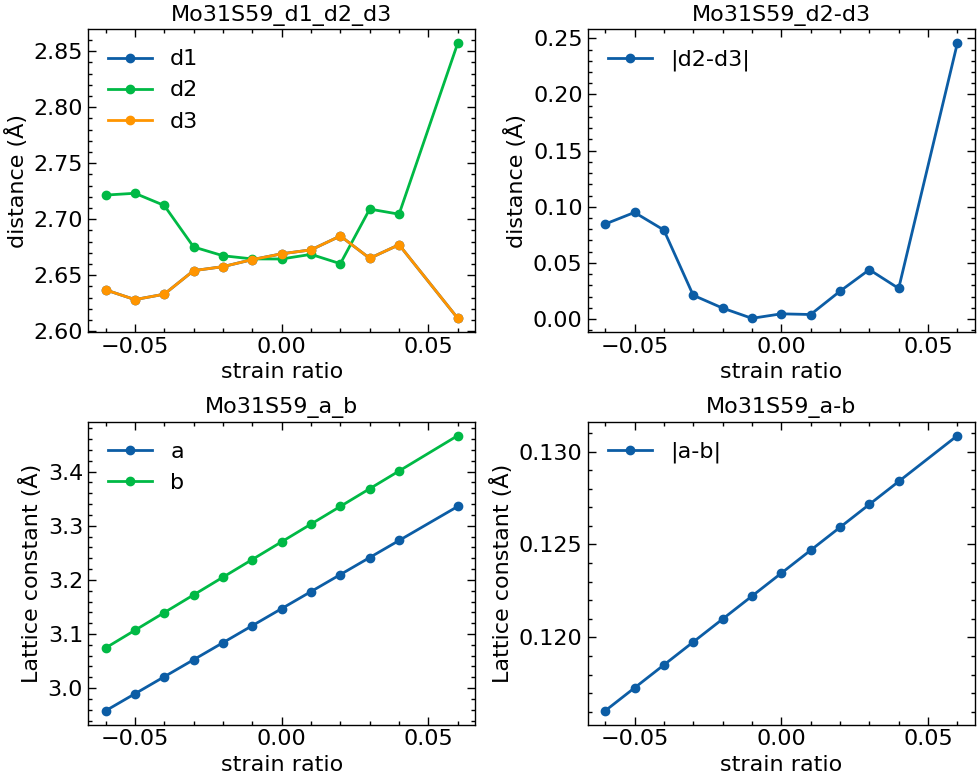

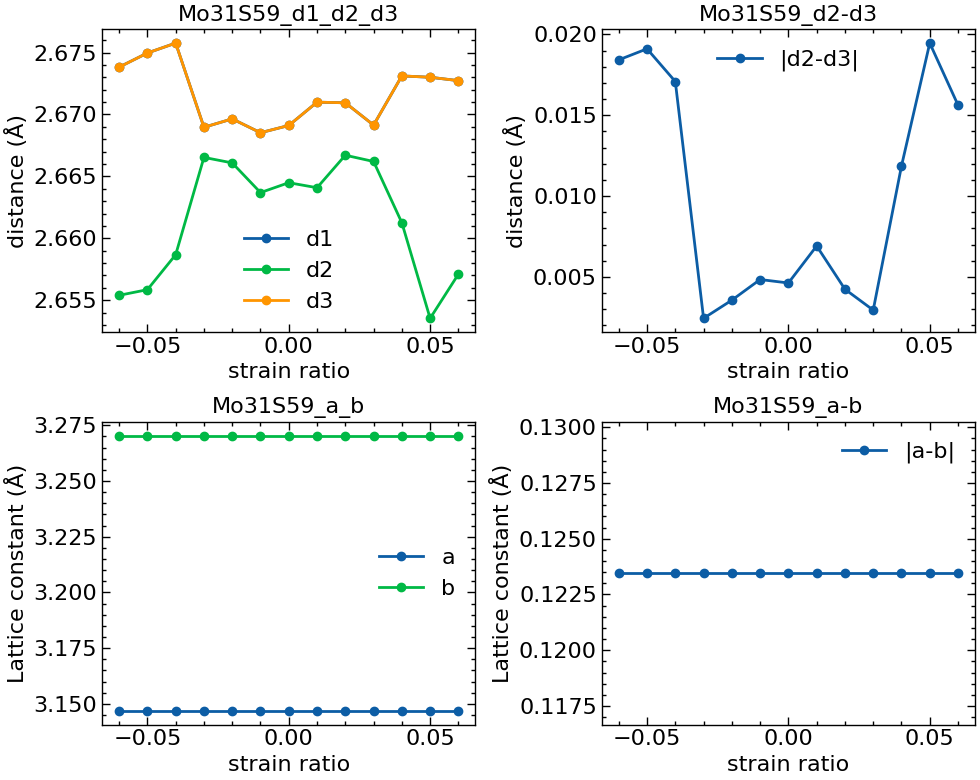

In [345]:
# plot d1, d2, and d3 for each strain component
for strain_comp in [xx_yy_df, zz_df]:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(2, 2, 1)
    ax.plot(strain_comp["strain_ratio"], strain_comp["d1"], label="d1", marker="o")
    ax.plot(strain_comp["strain_ratio"], strain_comp["d2"], label="d2", marker="o")
    ax.plot(strain_comp["strain_ratio"], strain_comp["d3"], label="d3", marker="o")
    ax.set_xlabel("strain ratio")
    ax.set_ylabel("distance (Å)")
    ax.set_title(strain_comp["formula"].iloc[0]+"_d1_d2_d3")
    ax.legend()

    ax = fig.add_subplot(2, 2, 2)
    d2_sub_d3 = strain_comp["d2"] - strain_comp["d3"]
    ax.plot(strain_comp["strain_ratio"], np.abs(d2_sub_d3), label="|d2-d3|", marker="o")
    ax.set_xlabel("strain ratio")
    ax.set_ylabel("distance (Å)")
    ax.set_title(strain_comp["formula"].iloc[0]+"_d2-d3")
    ax.legend()

    # plot a and b
    ax = fig.add_subplot(2, 2, 3)
    ax.plot(strain_comp["strain_ratio"], strain_comp["a"], label="a", marker="o")
    ax.plot(strain_comp["strain_ratio"], strain_comp["b"], label="b", marker="o")
    ax.set_xlabel("strain ratio")
    ax.set_ylabel("Lattice constant (Å)")
    ax.set_title(strain_comp["formula"].iloc[0]+"_a_b")
    ax.legend()

    #plot a-b
    ax = fig.add_subplot(2, 2, 4)
    ax.plot(strain_comp["strain_ratio"], np.abs(strain_comp["a"]-strain_comp["b"]), label="|a-b|", marker="o")
    ax.set_xlabel("strain ratio")
    ax.set_ylabel("Lattice constant (Å)")
    ax.set_title(strain_comp["formula"].iloc[0]+"_a-b")
    ax.legend()


    plt.tight_layout()
    plt.show()

In [346]:
# df.iloc[0]["structure"].to("poscar", "../structure/cubic_sc/strained_defect/95.vasp")

# ZFS plotting

## D & Structural info

In [351]:
def plot_D_structure(plot_df, plot_lattice="a"):
    for plt_idx, formula in enumerate(plot_df.sort_values(by="formula")["formula"].unique()):
        if "Te" in formula:
            continue
        fig = plt.figure(figsize=(10, 8))
        print(formula)
        zfs_lgt0 = plot_df.loc[(df["formula"] == formula) & (plot_df["strain_ratio"]>=0)].sort_values("strain_ratio")
        zfs_lte0 = plot_df.loc[(df["formula"] == formula) & (plot_df["strain_ratio"]<=0)].sort_values("strain_ratio")
        zfs_all = plot_df.loc[(df["formula"] == formula)].sort_values("strain_ratio")

    ############################3
        ax = fig.add_subplot(2, 2, 2)
        d2_sub_d3 = zfs_all["d2"] - zfs_all["d3"]

        ax.set_ylabel("distance (Å)")
        ax.plot(zfs_all["strain_ratio"], np.abs(d2_sub_d3), "o:", label="|d2-d3|")
        ax.plot(zfs_all["strain_ratio"], d2_sub_d3, "o:", label="d2-d3")
        ax.set_xlabel("Strain ratio")
        ax.set_title("|d2-d3|")
        ax.legend(fancybox=False, edgecolor="black")

        # plot curve fitting
        # strain_ratios = np.linspace(-0.06, 0.06, 100)
        # z1_fit = np.poly1d(np.polyfit(zfs_all["strain_ratio"], d2_sub_d3, 1))
        # ax.plot(strain_ratios, z1_fit(strain_ratios), "-", label="z fit")
        # # add fitting formula as text at the bottom left corner
        # ax.text(0.05, 0.05, r"$z = %.2f x + %.2f$" % tuple(z1_fit.coeffs),
        #         transform=ax.transAxes, fontsize=12, verticalalignment="bottom", bbox=dict(facecolor='white', alpha=0.5))

    ######################################3
        ax = fig.add_subplot(2, 2, 4)
        a_sub_b = zfs_all["a"] - zfs_all["b"]
        ax.set_ylabel("Lattice const. (Å)")
        ax.plot(zfs_all["strain_ratio"], np.abs(a_sub_b), "o:", label="|a-b|")

        ax.set_xlabel("Strain ratio")
        ax.set_title(f"|a-b|")
        ax.legend(fancybox=False, edgecolor="black")

        # plot curve fitting
        # strain_ratios = np.linspace(-0.06, 0.06, 100)
        # as_ = zfs_all[plot_lattice].values
        # a_fit = np.poly1d(np.polyfit(zfs_all["strain_ratio"], as_, 1))
        # ax.plot(strain_ratios, a_fit(strain_ratios), "-", label="a fit")
        # # add fitting formula as text at the bottom right corner
        # ax.text(0.35, 0.05, r"$a = %.2f x + %.2f$" % tuple(a_fit.coeffs),
        #         transform=ax.transAxes, fontsize=12, verticalalignment="bottom", bbox=dict(facecolor='white', alpha=0.5))

    ###########################################3
        ax= fig.add_subplot(2, 2, 1)
        for idx, plot_df in enumerate([zfs_lgt0, zfs_lte0]):
            ax.plot(plot_df["strain_ratio"], plot_df["dD"], "o:")
            ax.set_ylabel("dD (GHz)")
            ax.set_xlabel("Strain ratio")
            ax.set_title(formula)

            # plot curve fitting
            strain_ratios = np.linspace(0, 0.06, 100) if idx == 0 else np.linspace(-0.06, 0, 100)
            Ds = plot_df["dD"].values
            D_fit = np.poly1d(np.polyfit(plot_df["strain_ratio"], Ds, 1))
            r2 = r2_score(plot_df["dD"], D_fit(plot_df["strain_ratio"]))
            slope = D_fit.coeffs[0].__round__(1)
            ax.plot(strain_ratios, D_fit(strain_ratios), "-", label=f"Strain>=0:{slope};{r2:.0%}" if idx == 0 else
            f"Strain<=0:{slope};{r2:.0%}")
            # set legend outside the at the top
            ax.legend(fancybox=False, edgecolor="black", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)


        ax = fig.add_subplot(2, 2, 3)
        for idx, plot_df in enumerate([zfs_lgt0, zfs_lte0]):
            ax.plot(plot_df["strain_ratio"], plot_df["dE"]*1000, "o:")
            ax.set_ylabel("dE (MHz)")
            ax.set_xlabel("Strain ratio")
            ax.set_title("dE")

            # plot curve fitting
            strain_ratios = np.linspace(0, 0.06, 100) if idx == 0 else np.linspace(-0.06, 0, 100)
            Es = plot_df["dE"].values
            E_fit = np.poly1d(np.polyfit(plot_df["strain_ratio"], Es, 1))
            r2 = r2_score(plot_df["dE"], E_fit(plot_df["strain_ratio"]))
            slope = E_fit.coeffs[0].__round__(1)
            ax.plot(strain_ratios, E_fit(strain_ratios)*1000, "-", label=f"Strain>=0:{slope};{r2:.0%}" if idx == 0 else
            f"Strain<=0:{slope};{r2:.0%}")
            ax.legend(fancybox=False, edgecolor="black", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

        fig.tight_layout()
        return fig




Mo31S59


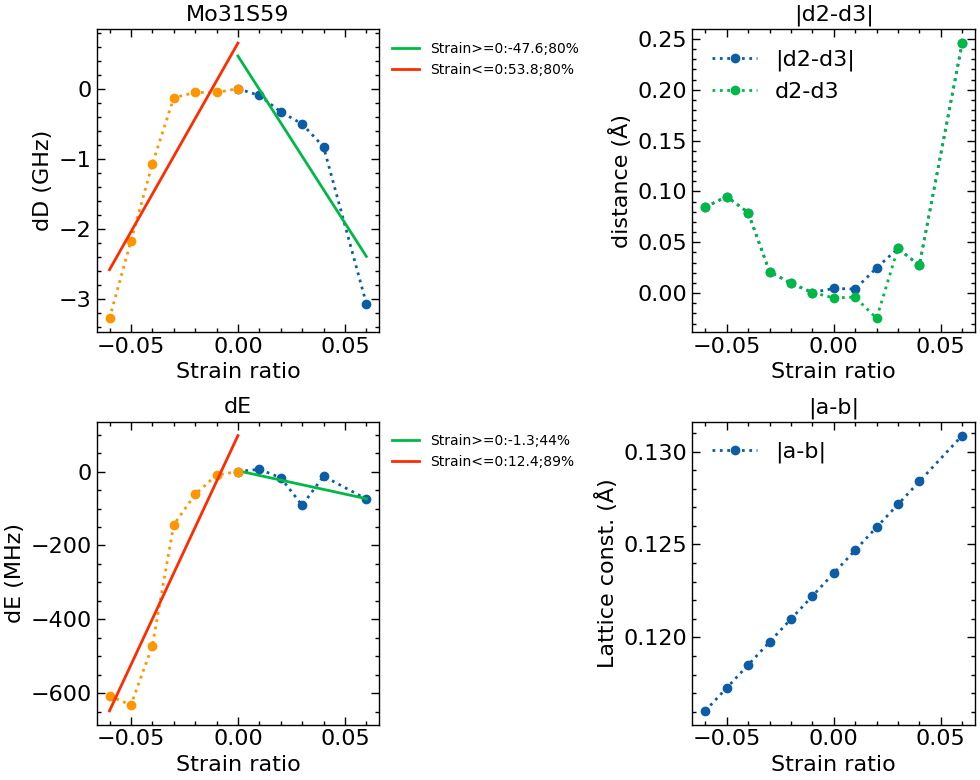

In [352]:
fig = plot_D_structure(xx_yy_df)
fig.show()

Mo31S59


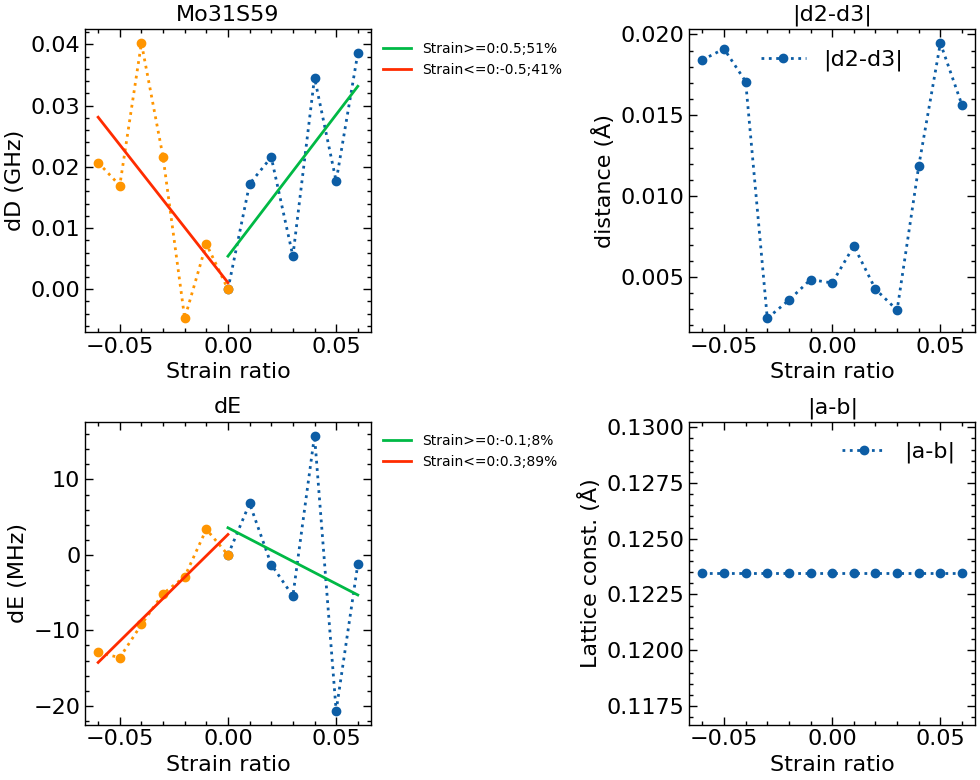

In [349]:
fig = plot_D_structure(zz_df, plot_lattice="c")